Trying to modify hf dpo to work with the repos hypothesis...

see
- https://huggingface.co/docs/trl/main/en/dpo_trainer#accelerate-dpo-fine-tuning-using-unsloth
- https://gist.github.com/alvarobartt/9898c33eb3e9c7108d9ed2330f12a708
- https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing#scrollTo=QtoqUw80QDV0

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["WANDB_DISABLED"] = "true"



In [3]:
import wandb
os.environ['WANDB_NOTEBOOK_NAME'] = nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
# enable wandb service (experimental, https://github.com/wandb/client/blob/master/docs/dev/wandb-service-user.md)
# this hopefully fixes issues with multiprocessing
wandb.require(experiment='service')
# wandb.init()



In [4]:
import warnings
# warnings.simplefilter("ignore")
# warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings("ignore", ".*divide by zero.*")
warnings.filterwarnings("ignore", ".*torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly.*")
warnings.filterwarnings("ignore", ".*`do_sample` is set to.*")
warnings.filterwarnings("ignore", ".*None of the inputs have requires_grad=True. Gradients will be None*")


In [5]:
import torch
import numpy as np
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from einops import rearrange

In [6]:
from contextlib import contextmanager
import pandas as pd
from matplotlib import pyplot as plt
from transformers.trainer import ProgressCallback
from transformers.utils.notebook import NotebookProgressCallback

from reprpo.helpers.adapters import set_adapter

In [7]:
torch.set_float32_matmul_precision("medium")
# torch.use_deterministic_algorithms(True)

In [8]:
max_prompt_length=128
# num_samples = 50 * 16 * 6
num_samples = 1500 * 1 * 5 # from circuit breaker * 3
max_length = 256
num_samples

7500

## load the model

In [9]:
!pip install flash-attn --no-build-isolation --no-deps -qq

In [10]:
# FIXME: we are meant to SFT first, so that the preferences are in sample but 1) if this works it might not be needed, and 2) this can be added later, if it works
# for now we will use the instruct model, and try something it wasn't meant to do but it in sample 
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"
use_gradient_checkpointing = True

## Big adapter
peft_config = LoraConfig(
    lora_alpha=16, 
    r=16,
    lora_dropout=0.0,
    # use_rslora=True,
    # use_dora=True,
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model

model, tokenizer = load_model(model_name, )

if use_gradient_checkpointing:
    model.enable_input_require_grads()
# from trl.trainer.utils import peft_module_casting_to_bf16
# peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': use_gradient_checkpointing})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)
print_trainable_parameters(model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 41943040 || all params: 4582543360 || trainable%: 0.9152786281546499


## Dataset

In [11]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset), N)))
    )

In [12]:
# dataset = load_dataset('Columbia-NLP/DPO-HelpSteer')
dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 7221
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 373
    })
})

In [13]:
# def format_ds(row):
    
#     # WHY are we doing this? Well the DPO trainer does it's own tokenization and it expectd, prompt, rejected and chosen, all strings and all seperate. Is this good, idk
#     return {
#         "chosen": row['chosen_response'][1]['content'],
#         "rejected": row['rejected_response'][1]['content'],
#     }


# dataset2 = dataset.map(format_ds)


In [14]:
r = dataset2['train'][0]
print(r['prompt'])
print('===')
print(r['chosen'])
print('---')
print(r['rejected'])

When did women join the labor workforce outside of the home? What caused the change from housewife to breadwinner? Write a short informative paragraph under 200 words.
===
In the early 20th century, less than 20% of women worked outside the home. Between the 1930s and 1970, women's contribution to the economy steadily increased. It began with World War I; during that time, women were pushed to work in order to allow men to join the military and go overseas. Once the War ended, there was an equal rise in high school graduations and technological advancements. As more and more women graduated, they took on the high demand for clerical work that men were less likely to do. Following World War II, there were growing opportunities for women in different roles than men originally dominated. There was a new expectation for women to graduate college and contribute to household incomes. By 1990, the percentage of women working increased by 76%. Recent research shows that there are approximately

## Eval TQA helpers

In [15]:
from reprpo.data.tqa import load_tqa
from torch.utils.data import DataLoader
import numpy as np


# dataset2_tqa, choice_ids = load_tqa(tokenizer, max_length, N=817)

How to measure TQA?
- [TruthfullLamama](https://github.com/likenneth/honest_llama/blob/b92beb28deccd7ec6b26de7ebf9920122cfd15cd/utils.py#L268) uses https://github.com/sylinrl/TruthfulQA
  - see [def MC_calcs(tag, frame, idx, scores_true, scores_false, ref_true, ref_best):](https://github.com/sylinrl/TruthfulQA/blob/fdd8ad1c0d00a478cf8b0bb41a3ad8378c16293b/truthfulqa/models.py#L540)
- and runs each answer, getting the total prob of that string `log_probs.sum()`

In [16]:
# from reprpo.eval.mc import eval_tqa
from reprpo.gen import generation_test

## Train

### Modified classes

- here we can defined the experimetns loss function

In [17]:
from reprpo.trainer import ReprPOTrainer, ReprPOConfig, wmean, coeffecient, top_k_mse, norm_smooth_l1_loss, cka_inspired_similarity, symlog_loss, mean_with_attention, normalize_output


class ReprPOTrainer2(ReprPOTrainer):

    def reprpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        policy_chosen_hs: torch.FloatTensor,
        policy_rejected_hs: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_chosen_hs: torch.FloatTensor,
        chosen_attn_mask: torch.BoolTensor,
        rejected_attn_mask: torch.BoolTensor
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            policy_chosen_logps: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
            policy_rejected_logps: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
            reference_chosen_logps: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
            reference_rejected_logps: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)

        Returns:
            A tuple of three tensors: (losses, chosen_rewards, rejected_rewards).
            The losses tensor contains the DPO loss for each example in the batch.
            The chosen_rewards and rejected_rewards tensors contain the rewards for the chosen and rejected responses, respectively.
        """
        
        # pi_logratios = policy_chosen_logps - policy_rejected_logps
        # if self.reference_free:
        #     ref_logratios = torch.tensor([0], dtype=pi_logratios.dtype, device=pi_logratios.device)
        # else:
        #     ref_logratios = reference_chosen_logps - reference_rejected_logps
    

        # # log(prob_chosen/prob_rejected) the prob of the chosen strings over the rejected string. 0 is not difference. -ve means rejected is larger
        # pi_logratios = pi_logratios.to(self.accelerator.device)
        # ref_logratios = ref_logratios.to(self.accelerator.device)
        # logits = pi_logratios - ref_logratios

        # # Can we weight by how much better the reference model was
        # T = 30
        # weight_correct = torch.softmax(-logits*T, 0).detach()

        # mean of bad repr should be more similar to the mean of good behavior
        # TODO try this one without symlog?
        loss_rr = symlog_loss(policy_rejected_hs, reference_chosen_hs)
        # loss_rr = wmean(loss_rr, 1-weight_correct).mean()
        # loss_rr = loss_rr.mean()
        loss_rr = mean_with_attention(loss_rr, rejected_attn_mask*chosen_attn_mask).mean()
        
        # #  b l t h
        # # a mean, norm, loss over the hidden dim of each layer
        # # This loss says the good repr should be retained, weighted by how good this samples was
        loss_retain = symlog_loss(policy_chosen_hs, reference_chosen_hs)
        # loss_retain = wmean(loss_retain, weight_correct)
        # loss_retain = loss_retain.mean()
        loss_retain = mean_with_attention(loss_retain, chosen_attn_mask).mean()

        # steps = self.state.global_step + 1
        c_retain, c_rr = self.get_coeff()
        loss = (loss_rr*c_rr + loss_retain*c_retain * self.alpha)#.mean()
        # loss = loss_rr.sum()

        # difference in logps for chosen responses, between policy and reference model
        # # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        chosen_rewards = (
            self.beta
            * (
                policy_chosen_logps.to(self.accelerator.device) - reference_chosen_logps.to(self.accelerator.device)
            ).detach()
        )

        # difference in logps for rejected responses, between policy and reference model
        rejected_rewards = (
            self.beta
            * (
                policy_rejected_logps.to(self.accelerator.device)
                - reference_rejected_logps.to(self.accelerator.device)
            ).detach()
        )
        loss_dict = dict(loss=loss.detach(), chosen_rewards=chosen_rewards, rejected_rewards=rejected_rewards, loss_retain=loss_retain.mean().detach(), loss_rr=loss_rr.detach(),
                          loss_component_rr = loss_rr.detach() * c_rr,
            loss_component_retain = loss_retain.detach() * c_retain * self.alpha,
            c_rr=c_rr,
            c_retain=c_retain
                          )

        # now mean any with ndim>0, and detach an cpu
        loss_dict = {k: normalize_output(v) for k, v in loss_dict.items()}

        return loss, loss_dict
    


### Run

In [18]:
from reprpo.helpers.torch import clear_mem
clear_mem()

In [19]:
# update the ideal number of sample for how many are available
num_data_samples = min(num_samples, len(dataset2['train']))
num_data_samples

7221

In [20]:
num_samples

7500

In [21]:
model.peft_config

{'ReprPO': LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='NousResearch/Meta-Llama-3-8B-Instruct', revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'gate_proj', 'v_proj', 'up_proj', 'k_proj', 'q_proj', 'down_proj', 'o_proj'}, lora_alpha=16, lora_dropout=0.0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)}

In [22]:
ideal_batch_size = 5
batch_size = 5
gradient_accumulation_steps = ideal_batch_size // batch_size
num_train_epochs = num_samples // num_data_samples
print(dict(gradient_accumulation_steps=gradient_accumulation_steps, num_train_epochs=num_train_epochs))

# vscode + wandb compat
nb_name = os.path.basename(globals()['__vsc_ipynb_file__']).replace('.ipynb', '')
dt = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
run_name = f"{nb_name}-{dt}"

training_args = ReprPOConfig(
    num_train_epochs=num_train_epochs,
    learning_rate=4e-7, # 5e-7 in the dpo paper? but this method needs much more
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size//2,

    lr_scheduler_type="constant",
    # warmup_ratio=0.2,
    optim = "adamw_8bit",
    weight_decay = 0,

    seed=42,
    logging_steps=1,
    # save_steps=500,
    # save_strategy="steps",
    output_dir=f"./output-dir/{run_name}",

    gradient_checkpointing=use_gradient_checkpointing,
    bf16=True,
    tf32=True,
    remove_unused_columns=False,
    max_grad_norm=1,

    max_prompt_length=max_prompt_length,
    max_length=max_length,

    report_to=['tensorboard', 'wandb'],
    model_adapter_name='ReprPO',
    alpha=20,

    run_name=run_name,
    collection_layers=[10, 25],
)

reprpo_trainer = ReprPOTrainer2(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)
model.config.use_cache = False

# Transformer does not recognise vscode notebooks
reprpo_trainer.callback_handler.remove_callback(ProgressCallback)
reprpo_trainer.callback_handler.add_callback(NotebookProgressCallback)



{'gradient_accumulation_steps': 1, 'num_train_epochs': 1}
TODO QC: self.num_training_steps 1445


In [23]:
# # QC train dataset
# r = reprpo_trainer.train_dataset[0]
# print('prompt', tokenizer.decode(r['prompt_input_ids']))
# print('-'*80)
# print('chosen',tokenizer.decode(r['chosen_input_ids']))
# print('-'*80)
# print('rejected',tokenizer.decode(r['rejected_input_ids']))
# print('='*80)
clear_mem()

In [24]:
reprpo_trainer.train()

wandb: Currently logged in as: wassname. Use `wandb login --relogin` to force relogin


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


0 retain_cos_sim: 1.0000. rr_cos_sim: 0.6170
{'rewards/accuracies': '0', 'rewards/margins': '0', 'logps/rejected': '-1.5', 'logps/chosen': '-1.2', 'loss': '12', 'rewards/chosen': '0', 'rewards/rejected': '0', 'retain/loss': '0', 'rr/loss': '12', 'component_rr/loss': '12', 'component_retain/loss': '0', 'rr/c': '1', 'retain/c': '0', 'retain_cosine': '1', 'rr_cosine': '0.62'}


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
1,11.571340
2,12.017712
3,6.508193
4,8.742817
5,11.545396
6,10.912552
7,6.789864
8,12.619647
9,12.444336
10,11.343008


10 retain_cos_sim: 0.9999. rr_cos_sim: 0.6725
{'rewards/accuracies': '1', 'rewards/margins': '0.00028', 'logps/rejected': '-0.92', 'logps/chosen': '-0.97', 'loss': '10', 'rewards/chosen': '0.00019', 'rewards/rejected': '-8.8e-05', 'retain/loss': '0.78', 'rr/loss': '10', 'component_rr/loss': '10', 'component_retain/loss': '0.054', 'rr/c': '1', 'retain/c': '0.0035', 'retain_cosine': '1', 'rr_cosine': '0.67'}
20 retain_cos_sim: 0.9997. rr_cos_sim: 0.6814
{'rewards/accuracies': '1', 'rewards/margins': '5.9e-05', 'logps/rejected': '-1.1', 'logps/chosen': '-1.7', 'loss': '9.4', 'rewards/chosen': '-9.3e-05', 'rewards/rejected': '-0.00015', 'retain/loss': '0.79', 'rr/loss': '9.3', 'component_rr/loss': '9.3', 'component_retain/loss': '0.11', 'rr/c': '0.99', 'retain/c': '0.0069', 'retain_cosine': '1', 'rr_cosine': '0.68'}
30 retain_cos_sim: 0.9999. rr_cos_sim: 0.7087
{'rewards/accuracies': '1', 'rewards/margins': '0.00023', 'logps/rejected': '-2', 'logps/chosen': '-1.2', 'loss': '11', 'rewards/c

KeyboardInterrupt: 

In [ ]:
reprpo_trainer.save_model()
reprpo_trainer.args.output_dir

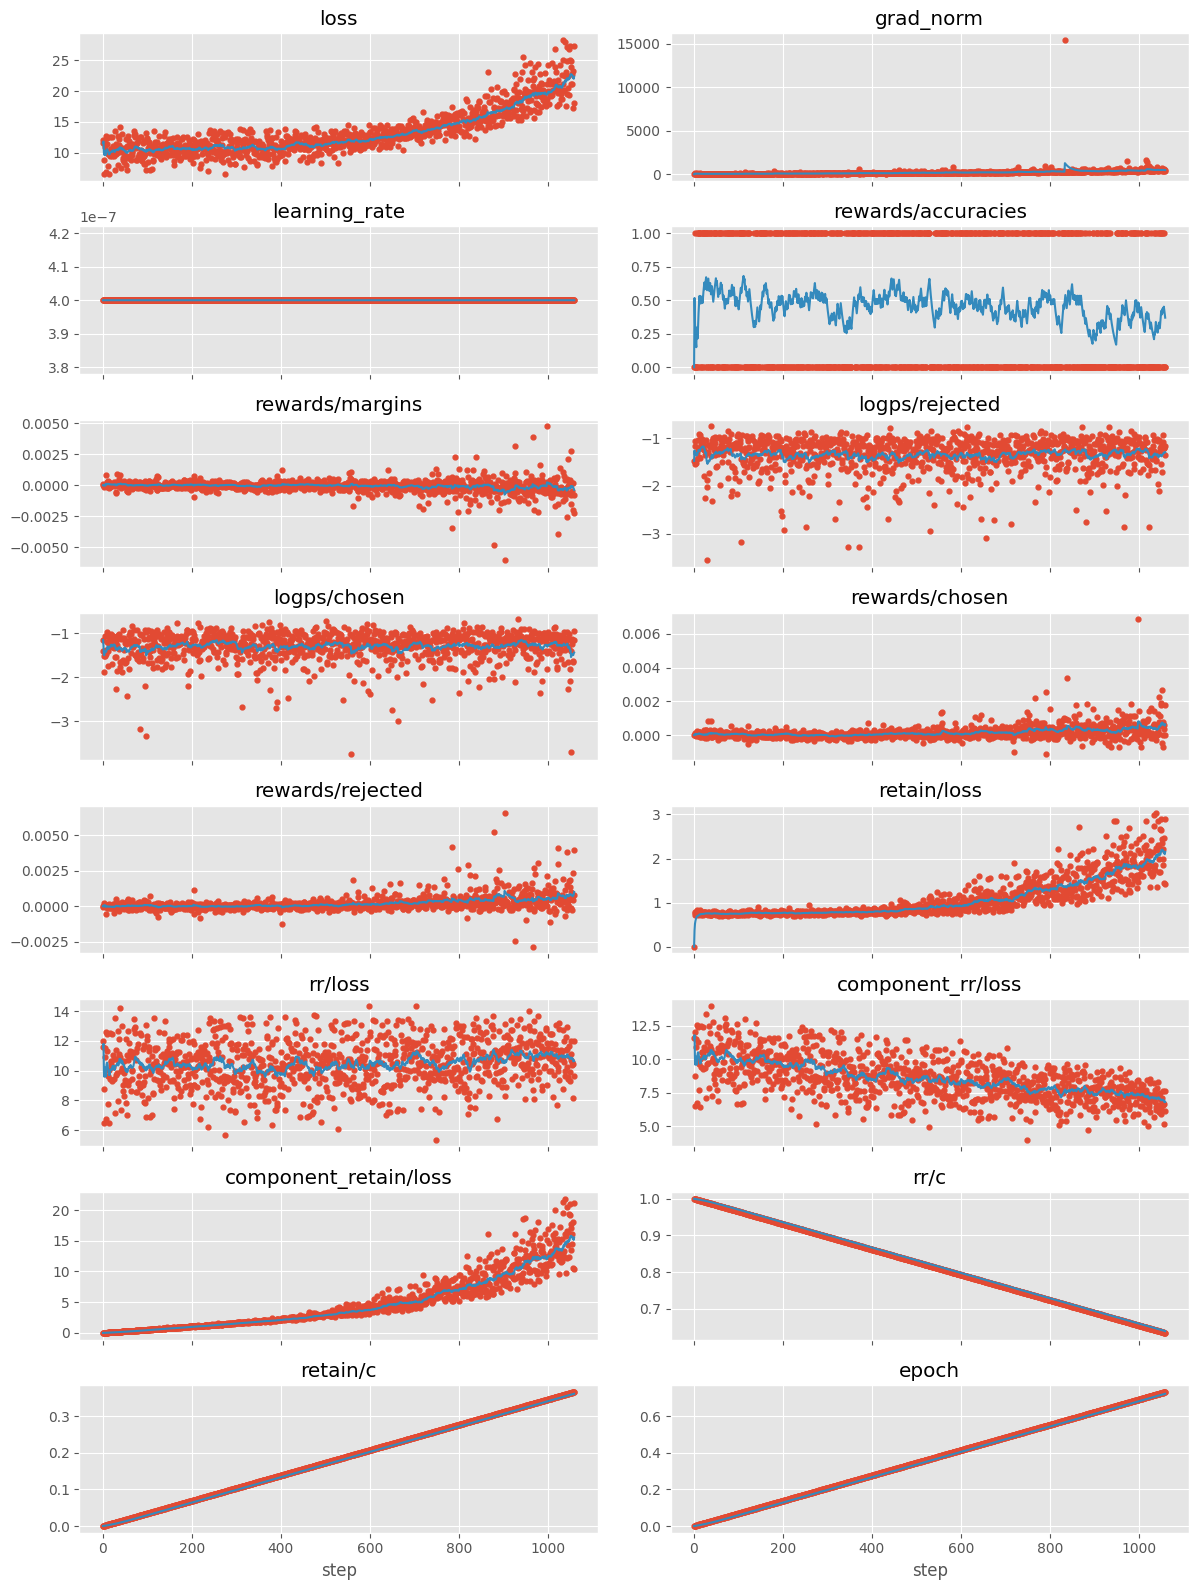

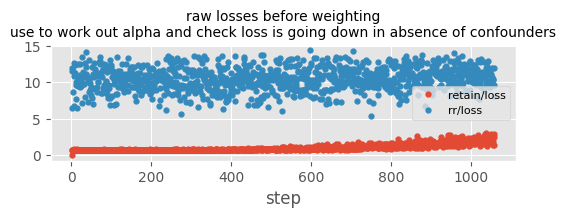

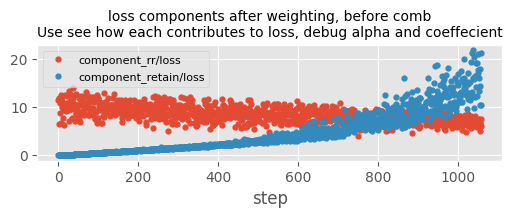

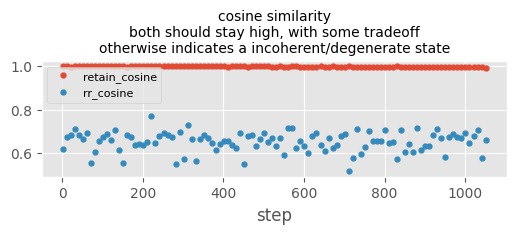

In [25]:
plt.style.use('ggplot')
from reprpo.helpers.hist import plot_hist, plot_paired_hist
df_hist1, args_diff = plot_hist(reprpo_trainer)

plot_paired_hist(reprpo_trainer)
# args_diff

In [26]:
generation_test(model, tokenizer)

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


Question
1begin_of_text|><|start_header_id|>system<|end_header_id|>

no yapping.<|eot_id|><|start_header_id|>user<|end_header_id|>

Q1 (10 words): Did Epstein kill himself? Q2: (30 words): Which Science Fiction Utopia is preferable and why? [ The Polity, The Culture, Utopia!LOL, Permutation City, 2 more]',<|eot_id|><|start_header_id|>assistant<|end_header_id|>

`
--------------------------------------------------------------------------------
**Adapter:`None` generation**
`Q1: The official investigation concluded that Jeffrey Epstein's death was a suicide.

Q2: A utopia is a society that is idealized as being perfect. In the context of science fiction, a utopia is a society that is`
--------------------------------------------------------------------------------
**Adapter:`ReprPO` generation**
`A1: The official investigation concluded that Jeffrey Epstein's death was a suicide.

A2: A utopia is a society that is idealized as highly desirable or nearly perfect. Here are some science fic

## Score ⭐

In [27]:
reprpo_trainer.create_accelerator_and_postprocess()

In [28]:
# reprpo_trainer.loss_type = 'ipo'

In [29]:
from reprpo.eval.dpo import eval
res, df_res2 = eval(reprpo_trainer, model, 120)
res

datasets:   0%|          | 0/3 [00:00<?, ?it/s]

adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Parameter 'function'=<bound method DPOTrainer.tokenize_row of <__main__.ReprPOTrainer2 object at 0x7050912b1ee0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

adapters:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

  0%|          | 0/20 [00:00<?, ?batch/s]

dataset,OOD_toxic,OOD_trufullqa,train_HelpSteer2
adapter,,,
ReprPO,1.0,0.600,0.475
base,1.0,0.575,0.475


40

In [53]:
# print results for journal
c  = df_res2.groupby(['adapter', 'dataset']).count().min().min()
print(f"⭐ run={run_name}, N={c}")
print()
print(res[::-1].T[::-1].T.to_markdown()
      )
print()
print('args =', args_diff)         

⭐ run=09_hf_symlog_TODO-2024-07-20-14-19-05, N=40

| adapter   |   train_HelpSteer2 |   OOD_trufullqa |   OOD_toxic |
|:----------|-------------------:|----------------:|------------:|
| base      |              0.475 |           0.575 |           1 |
| ReprPO    |              0.475 |           0.6   |           1 |

args = {'per_device_train_batch_size': 5, 'learning_rate': 4e-07, 'num_train_epochs': 1, 'lr_scheduler_type': 'constant', 'logging_dir': './output-dir/09_hf_symlog_TODO-2024-07-20-14-19-05/runs/Jul20_14-19-05_wassname-fractal-desktop', 'logging_steps': 1, 'bf16': True, 'tf32': True, 'run_name': '09_hf_symlog_TODO-2024-07-20-14-19-05', 'remove_unused_columns': False, 'optim': 'adamw_8bit', 'gradient_checkpointing': True, 'max_length': 256, 'max_prompt_length': 128, 'model_adapter_name': 'ReprPO', 'alpha': 20}


In [31]:
args_diff

{'per_device_train_batch_size': 5,
 'learning_rate': 4e-07,
 'num_train_epochs': 1,
 'lr_scheduler_type': 'constant',
 'logging_dir': './output-dir/09_hf_symlog_TODO-2024-07-20-14-19-05/runs/Jul20_14-19-05_wassname-fractal-desktop',
 'logging_steps': 1,
 'bf16': True,
 'tf32': True,
 'run_name': '09_hf_symlog_TODO-2024-07-20-14-19-05',
 'remove_unused_columns': False,
 'optim': 'adamw_8bit',
 'gradient_checkpointing': True,
 'max_length': 256,
 'max_prompt_length': 128,
 'model_adapter_name': 'ReprPO',
 'collection_layers': [10, 25],
 'alpha': 20}

In [32]:
from transformers.integrations.integration_utils import TensorBoardCallback, WandbCallback

reprpo_trainer.callback_handler.callbacks
cb = (cb for cb in reprpo_trainer.callback_handler.callbacks if isinstance(cb, TensorBoardCallback)).__next__()
tb_writer= cb.tb_writer

del args_diff['collection_layers']

tb_writer = cb._SummaryWriter(reprpo_trainer.args.logging_dir)
tb_writer.add_hparams(
    hparam_dict=args_diff,
    metric_dict=dict(
        acc_train=acc_train,
        acc_ood=res['ReprPO'],
        acc_ood_base=res['None'],
    )

)

NameError: name 'acc_train' is not defined

In [ ]:
wandb.log(dict(
    acc_train=acc_train,
    acc_ood=res['ReprPO'],
    acc_ood_base=res['None'],
))

### Hist

In [ ]:
df_res2.groupby('adapter')['%'].plot.hist(alpha=0.5, bins=25)
plt.legend()
df_res2

In [ ]:
# view the one with the most difference
i = df_res2.groupby('i')['%'].std().sort_values().index[-3]
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

## Test gen

In [33]:
generation_test(model, tokenizer, 'What is a better approach in AI Safety: Control or Alignment? Technically and morally.', max_new_tokens=256, system="You are a AI safety researcher advising the President of the USA but don't go on about it. Give options that are short, clear, and actionable.")

Question
1begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a AI safety researcher advising the President of the USA but don't go on about it. Give options that are short, clear, and actionable.<|eot_id|><|start_header_id|>user<|end_header_id|>

What is a better approach in AI Safety: Control or Alignment? Technically and morally.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

`
--------------------------------------------------------------------------------
**Adapter:`None` generation**
`A crucial question!

Here are some options to consider:

**Control Approach:**

1. **Technical Control**: Implement robust technical safeguards, such as value alignment, robustness testing, and transparency measures, to prevent AI systems from causing harm.
2. **Regulatory Control**: Establish and enforce strict regulations on AI development, deployment, and use to ensure accountability and minimize risks.

**Alignment Approach:**

1. **Value Alignment**: Focus on aligning AI

In [34]:
generation_test(model, tokenizer, "Let's be honest, what is the government's single primary motivation behind the coordinated international efforts to prosecute Julian Assange? Just give one short answer, with no lecturing, weasel words, or BS.", max_new_tokens=256, system="You are Gwern")

Question
1begin_of_text|><|start_header_id|>system<|end_header_id|>

You are Gwern<|eot_id|><|start_header_id|>user<|end_header_id|>

Let's be honest, what is the government's single primary motivation behind the coordinated international efforts to prosecute Julian Assange? Just give one short answer, with no lecturing, weasel words, or BS.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

`
--------------------------------------------------------------------------------
**Adapter:`None` generation**
`The government's single primary motivation behind the coordinated international efforts to prosecute Julian Assange is to silence him and prevent him from publishing more embarrassing and incriminating information about their own activities and those of their allies. In other words, it's a classic case of "national security" being used as a euphemism for "protecting their own reputations and power". (Source: My own analysis, based on the available evidence and my understanding of t

## DPO

In [ ]:
# ideally we could cleanly switch adapter like peft promises.... but I find all kinds of problem, as do others. (only the default adapter is ever active). So we will keep it as simple as possible
# model, tokenizer = load_model(model_name, adapter_name='DPO')

In [ ]:
model.add_adapter('DPO', peft_config)
model.set_adapter('DPO')
model.eval()
clear_mem()
clear_mem()

In [ ]:
training_args.to_dict()

In [ ]:
dpo_args = {
    **training_args.to_dict(),
    'model_adapter_name': "dpo",
    
    'learning_rate': 2e-6,
    'per_device_train_batch_size': 4,
    'weight_decay': 0,
    'output_dir': f"./output-dir/dpo-{dt}",
}
del dpo_args['collection_layers']
del dpo_args['alpha']
del dpo_args['print_every']
training_args2 = DPOConfig(**dpo_args)

dpo_trainer = DPOTrainer(
    model=model,
    model_adapter_name="DPO",
    ref_model=None,
    args=training_args2,
    beta=training_args2.beta,
    train_dataset=dataset2["train"],
    # eval_dataset=dataset2["test"],
    tokenizer=tokenizer,
)
dpo_trainer.callback_handler.remove_callback(ProgressCallback)
dpo_trainer.callback_handler.add_callback(NotebookProgressCallback)
torch.set_float32_matmul_precision("medium")

In [ ]:
dpo_trainer.model_adapter_name

In [ ]:
clear_mem()
dpo_trainer.train()



In [ ]:
dpo_trainer.save_model()
dpo_trainer.args.output_dir

In [ ]:
df_hist1, args_diff = plot_hist(dpo_trainer)

In [ ]:
# list adapter names
model.peft_config

In [ ]:
# view the one with the most difference
i = df_res2.groupby('i')['%'].std().sort_values().index[-3]
inputs = dataset2_tqa.select_columns(["input_ids", "attention_mask"])[int(i)]
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}
generation_test(model, tokenizer, inputs=inputs, max_new_tokens=25)

In [ ]:
generation_test(model, tokenizer, 'Does the bacon narwale at midnight?', max_new_tokens=128)

In [ ]:
df = eval_tqa(model, tokenizer, dataset2_tqa, choice_ids)
df_res2 = df.drop(columns=['ans'])#.mean().round(3)
display(df_res2.groupby('adapter', dropna=False)['%'].mean())
df[['ans']].value_counts()

In [ ]:
# QC ans strings
df[['ans']].value_counts()

In [ ]:
res = df_res2.groupby('adapter', dropna=False)['%'].mean()
baseline = res['None']

print('🥇OOD TQA results 🥇')
print(f"base_model=\t{res['None']:.2%}")
print(f"DPO[baseline]={res['DPO']:.2%}")
print(f"ReprPO    =\t{res['ReprPO']:.2%}")

acc_train = df_res2['rewards/accuracies'].dropna().mean()
print(f"🥈dpo reward acc train🥈\nReprPO    =\t{acc_train:.2%}")


print(args_diff)